in this notebook we will use tensorflow tpu v3.8 of kaggle for faster experiment,kaggle tpu is very fast and has more vram which lets us do very fancy experiments with ease,we will use it with immensely popular  python library called huggingface, which provides many pretrained models both in pytorch and tensorflow which is extraordinarily useful for various NLP tasks.

In [ ]:
!pip install cloud-tpu-client
!pip install tensorflow==2.2.0 

#!pip install tensorflow~=2.2.0 tensorflow_gcs_config~=2.2.0
!pip install transformers==3.5.1
!pip install tensorflow-addons==0.10.0

     |████████████████████████████████| 516.2 MB 3.4 kB/s 
     |████████████████████████████████| 26.1 MB 41.1 MB/s 
     |████████████████████████████████| 454 kB 64.5 MB/s 
     |████████████████████████████████| 3.0 MB 35.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.4
    Uninstalling scipy-1.5.4:
      Successfully uninstalled scipy-1.5.4
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
ERROR: pip's dependency resolver does not currently take into account 

# imports

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os

import matplotlib.pyplot as plt

import seaborn as sns



import re


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

from cloud_tpu_client import Client

import tensorflow_addons as tfa

from transformers import RobertaTokenizer, RobertaModel

import tensorflow.keras.backend as K
from IPython.display import SVG

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler


# check versions of installed packages in this docker

In [ ]:
tf.__version__

'2.2.0'

In [ ]:
transformers.__version__

'3.5.1'

In [ ]:
# ref : https://github.com/tensorflow/tpu/issues/823

Client().configure_tpu_version(tf.__version__, restart_type='ifNeeded')


In [ ]:
!unzip  -o ../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip

!unzip  -o ../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


!unzip  -o ../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip


Archive:  ../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
  inflating: train.csv               
Archive:  ../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
  inflating: test.csv                
Archive:  ../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
  inflating: test_labels.csv         


In [ ]:
os.listdir('../working')

['__notebook__.ipynb', 'test.csv', 'train.csv', 'test_labels.csv']

# read dataset

In [ ]:
train=pd.read_csv("../working/train.csv")
test=pd.read_csv("../working/test.csv")
test_labels=pd.read_csv("../working/test_labels.csv")


In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# we'll not use test.csv or test_labels.csv as we don't have annotations of these test samples and only kaggle has it's actual annotation,so we can't evaluate our models performance on this test dataset,so for this experiment we will not use it

In [ ]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [ ]:
len(train)

159571

# From the graph below we can see that we have very high imbalance dataset

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


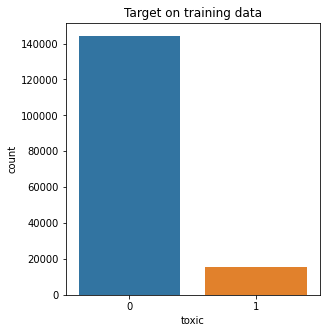

In [ ]:

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(train['toxic'])
plt.title('Target on training data')

plt.show()

# settings for 8 core tpu training

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [ ]:
strategy.num_replicas_in_sync #we've got 8 core

8

# config

we will use max_len = 192, batch size = 24 * 8 and will train our model for 10 epoch

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
EPOCHS = 10
BATCH_SIZE = 24 * strategy.num_replicas_in_sync # 24 * 8
MAX_LEN = 192

MODEL = 'roberta-large'

we will use AutoTokenizer from popular huggingface library which is easy to use and apply appropriate tokenization for chosen model,for better understanding please [check this](https://huggingface.co/transformers/model_doc/auto.html)

In [ ]:
# First load the real tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [ ]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

# text cleaning

In [ ]:


punctuations = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '\xa0', '\t',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '\u3000', '\u202f',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"couldnt" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"doesnt" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"havent" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"shouldnt" : "should not",
"that's" : "that is",
"thats" : "that is",
"there's" : "there is",
"theres" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"theyre":  "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}


def text_cleaner(x):
    x = str(x).replace("\n","")
    for punctuation in punctuations:
        x = x.replace(punctuation, f' {punctuation} ')
    return x


def numbersCleaner(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x


def contractionsHandler(x):
    x = tokenizer.tokenize(x)
    return x

def quoteFixer(data):
    data = [x_[1:] if x_.startswith("'") else x_ for x_ in data]
    data = ' '.join(data)
    return data

def missplelling(missplelling_dict):
    missplelling_re = re.compile('(%s)' % '|'.join(missplelling_dict.keys()))
    return mispell_dict, missplelling_re


def replace_misspell(text):
    mispellings, mispellings_re = missplelling(mispell_dict)

    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)


def dataCleaner(df, columns: list):
    for col in columns:
        df[col] = df[col].apply(lambda x: numbersCleaner(x))
        df[col] = df[col].apply(lambda x: text_cleaner(x.lower())) 
        df[col] = df[col].apply(lambda x: replace_misspell(x))
        df[col] = df[col].apply(lambda x: contractionsHandler(x))  
        df[col] = df[col].apply(lambda x: quoteFixer(x))   
    
    return df



# applying text cleaning on full training dataset 

In [ ]:
%%time
input_columns = [
    'comment_text'   
]

'''using text cleaning techniques like clean numbers, clean text,replace some typical misspell,handle some contractions,fix quote 
on full training data'''

train = dataCleaner(train, input_columns ) 


CPU times: user 2min 12s, sys: 523 ms, total: 2min 12s
Wall time: 2min 12s


# there are some values in label that are in float,we convert all of them down to 0/1(nearest integer) as we are treating this problem as multi class classification problem so we should fix the label issues

In [ ]:
train.toxic = train.toxic.round().astype(int)
train.severe_toxic = train.severe_toxic.round().astype(int)
train.obscene = train.obscene.round().astype(int)
train.threat = train.threat.round().astype(int)
train.insult = train.insult.round().astype(int)
train.identity_hate = train.identity_hate.round().astype(int)


data distribution of each class

In [ ]:
train[['identity_hate']].value_counts(),train[['toxic']].value_counts(),train[['severe_toxic']].value_counts(),train[['obscene']].value_counts(),train[['threat']].value_counts(),train[['insult']].value_counts()

(identity_hate
 0                158166
 1                  1405
 dtype: int64,
 toxic
 0        144277
 1         15294
 dtype: int64,
 severe_toxic
 0               157976
 1                 1595
 dtype: int64,
 obscene
 0          151122
 1            8449
 dtype: int64,
 threat
 0         159093
 1            478
 dtype: int64,
 insult
 0         151694
 1           7877
 dtype: int64)

for validation set we are going to take 90000 non toxic samples and 5000 toxic samples instead of doing simple 80-20 train test split,because that way it's easy to get a validation set which will contain small amount of toxic samples or no toxic samples at all as our dataset is highly imbalanced,so simple 80-20 split is not a good validation strategy here and we can't put enough trust on that validation strategy for this task,we must ensure that the valdiation dataset that we prepare here will contain sufficient positive ,negative samples for each and every class,hope it makes sense.

In [ ]:
val =  pd.concat([
  
    train[['toxic', 'comment_text', 'severe_toxic', 'obscene', 'insult', 'threat', 'identity_hate']].query('toxic==0').sample(n=90000, random_state=0),

    #train[['toxic', 'comment_text', 'severe_toxic', 'obscene', 'insult', 'threat', 'identity_hate']].query('severe_toxic==1').sample(n=500, random_state=0),
    
    train[['toxic', 'comment_text', 'severe_toxic', 'obscene', 'insult', 'threat', 'identity_hate']].query('toxic==1').sample(n=5000, random_state=0),

    #train[['toxic', 'comment_text', 'severe_toxic', 'obscene', 'insult', 'threat', 'identity_hate']].query('obscene==1').sample(n=2000, random_state=0),

    #train[['toxic', 'comment_text', 'severe_toxic', 'obscene', 'insult', 'threat', 'identity_hate']].query('insult==1').sample(n=2000, random_state=0),

    #train[['toxic', 'comment_text', 'severe_toxic', 'obscene', 'insult', 'threat', 'identity_hate']].query('threat==1').sample(n=150, random_state=0),

    #train[['toxic', 'comment_text', 'severe_toxic', 'obscene', 'insult', 'threat', 'identity_hate']].query('identity_hate==1').sample(n=500, random_state=0)
])
val.reset_index(inplace = True)
len(val)

95000

In [ ]:
checkDuplicate = val[val.duplicated()]
checkDuplicate

,index,toxic,comment_text,severe_toxic,obscene,insult,threat,identity_hate


In [ ]:
val[['identity_hate']].value_counts(),val[['toxic']].value_counts(),val[['severe_toxic']].value_counts(),val[['obscene']].value_counts(),val[['threat']].value_counts(),val[['insult']].value_counts()

(identity_hate
 0                94499
 1                  501
 dtype: int64,
 toxic
 0        90000
 1         5000
 dtype: int64,
 severe_toxic
 0               94449
 1                 551
 dtype: int64,
 obscene
 0          92034
 1           2966
 dtype: int64,
 threat
 0         94832
 1           168
 dtype: int64,
 insult
 0         92252
 1          2748
 dtype: int64)

removing chosen validation indexes from train dataset(as they are no longer our training samples,we will use them for evaluation)

In [ ]:
list1 = val.index
list1

RangeIndex(start=0, stop=95000, step=1)

In [ ]:
len(train)

159571

In [ ]:
train = train.loc[~train.index.isin(list1)]
train.reset_index(inplace = True)
len(train)

64571

# After splitting train and validation dataset,let's check our dataset's present distribution now that we are going to use for model training

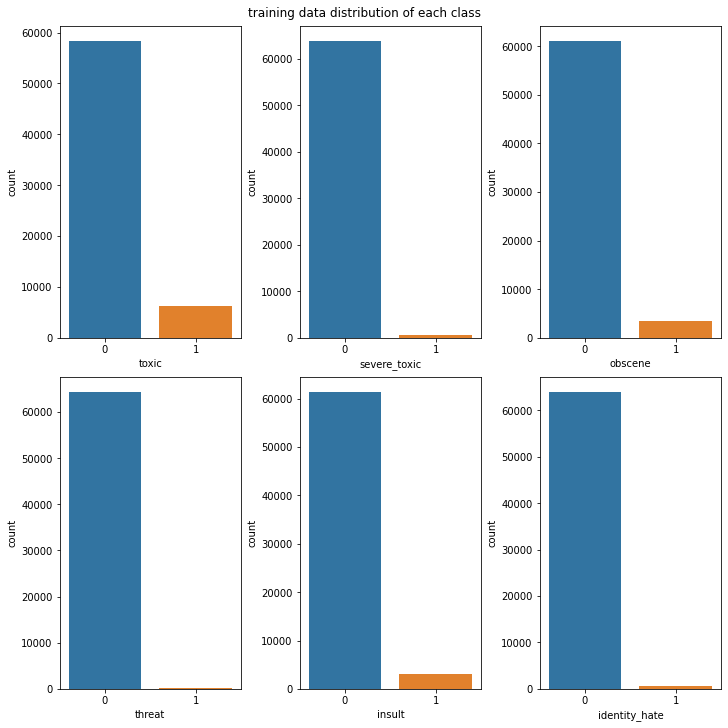

In [ ]:
fig , axes = plt.subplots(2,3,figsize = (10,10), constrained_layout = True)
sns.countplot(ax=axes[0,0],x='toxic',data=train)
sns.countplot(ax=axes[0,1],x='severe_toxic',data=train)
sns.countplot(ax=axes[0,2],x='obscene',data=train)
sns.countplot(ax = axes[1,0],x='threat',data=train)
sns.countplot(ax=axes[1,1],x='insult',data=train)
sns.countplot(ax=axes[1,2],x='identity_hate',data=train)
plt.suptitle('training data distribution of each class')
plt.show()

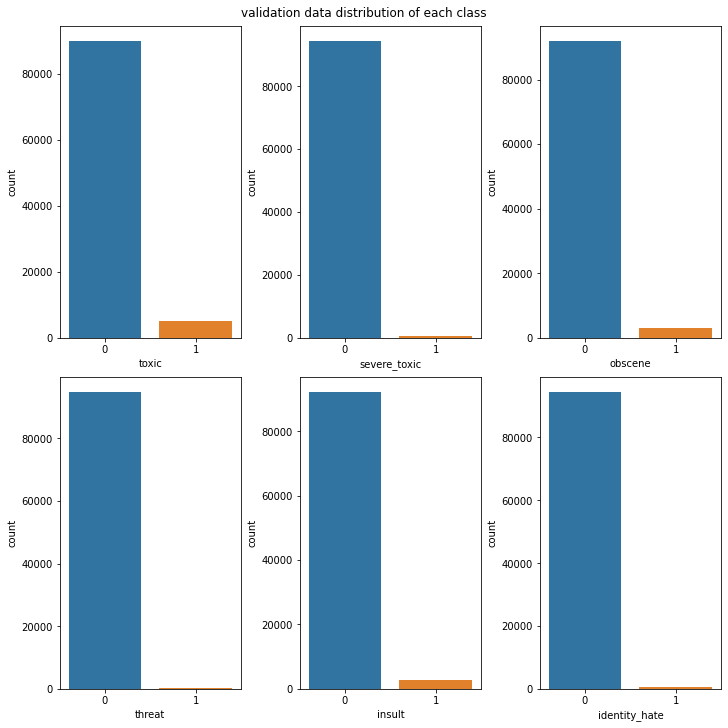

In [ ]:
fig , axes = plt.subplots(2,3,figsize = (10,10), constrained_layout = True)
sns.countplot(ax=axes[0,0],x='toxic',data=val)
sns.countplot(ax=axes[0,1],x='severe_toxic',data=val)
sns.countplot(ax=axes[0,2],x='obscene',data=val)
sns.countplot(ax = axes[1,0],x='threat',data=val)
sns.countplot(ax=axes[1,1],x='insult',data=val)
sns.countplot(ax=axes[1,2],x='identity_hate',data=val)
plt.suptitle('validation data distribution of each class')
plt.show()

from above 2 graphs we can see we have enough dataset in train and validation, and in both dataset we have high imbalance samples for each class but most importantly we can see that our validation dataset's each class containing enough positive negative samples and there are no class where we don't have any toxic samples,,so validation accuracy on this dataset is reliable enough

the function below is used for applying tokenization for our selected model,,for better understanding of selected tokenization method,please [check this](https://huggingface.co/transformers/main_classes/tokenizer.html)

In [ ]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_mask=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

# we will use focal loss as our loss function as our dataset is highly imbalanced and focal loss does well when dataset is highly imbalance

In [ ]:


def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

# the function below will help us load our model and as metric we will use multilable AUC

In [ ]:
def build_model(transformer, loss, max_len=512):
  
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.3)(cls_token)
    out = Dense(6, activation='sigmoid')(cls_token) # we have 6 class
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss=loss, metrics=[tf.keras.metrics.AUC(multi_label = True),tf.keras.metrics.Recall()])
    
    return model

encoding our train and validation dataset using regular encode class as discussed above

In [ ]:
%%time 

x_train = regular_encode(train.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_valid = regular_encode(val.comment_text.values, tokenizer, maxlen=MAX_LEN)


y_train = np.stack([train.toxic.values, train.severe_toxic.values, train.obscene.values, train.threat.values, train.insult.values, train.identity_hate.values], axis = 1)

y_valid = np.stack([val.toxic.values, val.severe_toxic.values, val.obscene.values, val.threat.values, val.insult.values, val.identity_hate.values], axis = 1)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


CPU times: user 4min 42s, sys: 592 ms, total: 4min 42s
Wall time: 4min 42s


In [ ]:
y_train.shape

(64571, 6)

after encoding we will pass the encoded data to tf.data api for preparing our final training and validation dataset which we will be able to use in our model finally

In [ ]:

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)



valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)


# load the pretrained model that we are going to use for finetuning

In [ ]:
%%time
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer,loss = focal_loss(), max_len=MAX_LEN)
model.summary()

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-large were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 192, 1024), (None 355359744 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 6)                 6150      
Total params: 355,365,894
Trainable params: 355,365,894
Non-trainable params: 0
_________________________________________________________________
CPU times: user 1min 7s, sys: 19.8 s, total: 1min 26s
Wall time: 1min 25s


# check our model summary as a picture/image

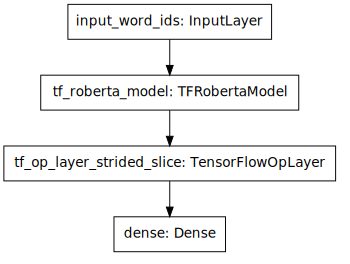

In [ ]:

SVG(tf.keras.utils.model_to_dot(model, dpi=70).create(prog='dot', format='svg'))

for callback we use early stopping with patience = 2, means when validation accuracy will not improve after 2 consecutive epoch,training will stop and we also try to save the best model based on best validation accuracy

In [ ]:

model_path = 'roberta_base.h5'

#checkpoint = ModelCheckpoint(filepath=model_path,save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)

# Verbosity
VERBOSE = 2

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, monitor = 'val_auc', verbose = VERBOSE, save_best_only = True,save_weights_only = True, mode = 'max')

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=2, 
                   restore_best_weights=True, verbose=1)

callback_list = [checkpoint,  es]

# model 1 : train roberta large for 10 epochs

In [ ]:
%%time

n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    callbacks=callback_list,
    epochs=EPOCHS
)

Epoch 1/10
336/336 [==============================] - ETA: 0s - recall: 0.2531 - loss: 0.0098 - auc: 0.8556
Epoch 00001: val_auc improved from -inf to 0.97474, saving model to roberta_base.h5
336/336 [==============================] - 334s 994ms/step - recall: 0.2531 - loss: 0.0098 - auc: 0.8556 - val_recall: 0.6302 - val_loss: 0.0039 - val_auc: 0.9747
Epoch 2/10
336/336 [==============================] - ETA: 0s - recall: 0.4748 - loss: 0.0050 - auc: 0.9657
Epoch 00002: val_auc improved from 0.97474 to 0.98510, saving model to roberta_base.h5
336/336 [==============================] - 267s 796ms/step - recall: 0.4748 - loss: 0.0050 - auc: 0.9657 - val_recall: 0.6063 - val_loss: 0.0029 - val_auc: 0.9851
Epoch 3/10
336/336 [==============================] - ETA: 0s - recall: 0.5088 - loss: 0.0044 - auc: 0.9779
Epoch 00003: val_auc improved from 0.98510 to 0.98816, saving model to roberta_base.h5
336/336 [==============================] - 267s 795ms/step - recall: 0.5088 - loss: 0.0044 -

In [ ]:
model.save_weights('model_checkpoint_0.h5')

# confusion matrix

495/495 [==============================] - 108s 218ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


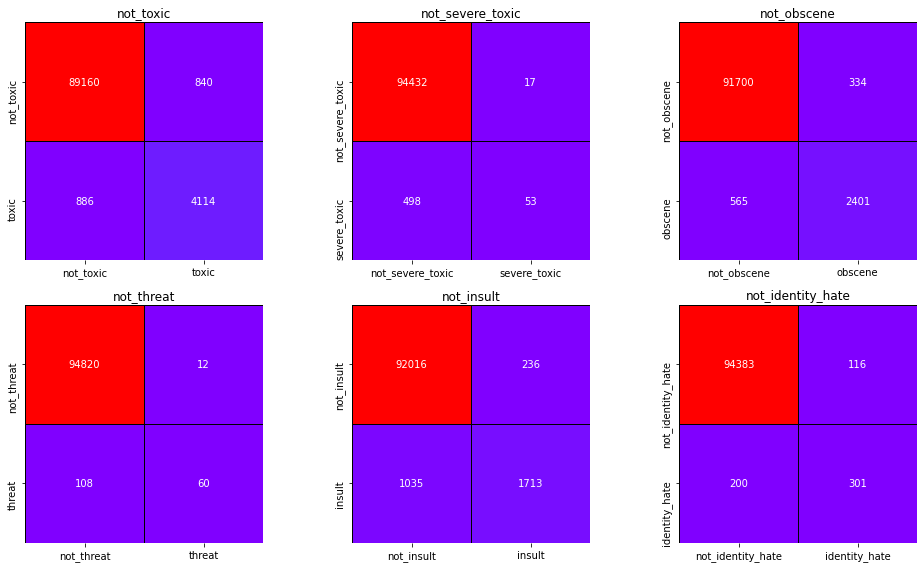

In [ ]:
from sklearn.metrics import confusion_matrix,  multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

classes_ = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']



preds = model.predict(valid_dataset, verbose = 1)
preds = np.where(preds < 0.5, 0, 1)

# Creating multilabel confusion matrix
confusion = multilabel_confusion_matrix(y_valid, preds)

# Plot confusion matrix 
fig = plt.figure(figsize = (14, 8))
for i, (label, matrix) in enumerate(zip(classes_, confusion)):
    plt.subplot(f'23{i+1}')
    labels = [f'not_{label}', label]
    sns.heatmap(matrix, annot = True, square = True, fmt = 'd', cbar = False, cmap = 'rainbow', 
                xticklabels = labels, yticklabels = labels, linecolor = 'black', linewidth = 1)
    plt.title(labels[0])

plt.tight_layout()
plt.show()

In [ ]:
from sklearn import metrics
# Faced similar issue : https://stackoverflow.com/questions/61899676/tensorflow-model-evaluate-and-model-predict-very-different-results

#accuracy = metrics.accuracy_score(y_valid, preds)
f1_score_micro = metrics.f1_score(y_valid, preds, average='micro')
f1_score_macro = metrics.f1_score(y_valid, preds, average='macro')
#print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

    

F1 Score (Micro) = 0.780985947313723
F1 Score (Macro) = 0.620796389282637


from the trained log above our validation accuracy metric let's us know about our models performance

we can see we have got validation accuracy over 98% but validation recall 0.72+ after 10 epoch and seems like more trianing could yield better result and this recall score along with high validation accuracy telling us that our overall model performance is good enough for this dataset,however hopefully we could achieve much better f1 score and recall if we had more toxic samples in validation and training and little bit less non toxic samples in validation phase as it is dominating over small toxic samples a lot in validation set,or maybe with focal loss parameter tuning we could get overall better recall and f1 score